<a href="https://colab.research.google.com/github/MitPitt/msu-nn-special-course/blob/main/%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Требуется реализовать метод обучения Q-learning или Deep Q-learning для любой из сред,  

Реализованных в OpenAI Gym (кроме Discrete Lunar Lander). 

Результатом задания является записная книжка Jupyter Notebook в которой: 
- Создается выбранная среда OpenAI Gym 
- Агент обучается методом Q-learning 
- Визуализируется (средствами OpenAI Gym) поведение обученного агента 

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()

In [2]:
import gym
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

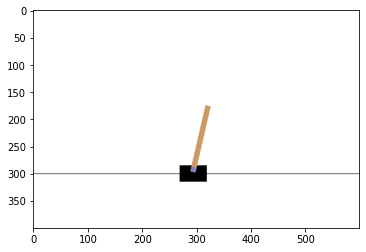

In [3]:
env = gym.make("CartPole-v1")

env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()

In [4]:
NA = 2
NS = 4

from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.activations import relu, linear

model = Sequential()
model.add(Dense(NS*NS, input_dim=NS, activation=relu))
model.add(Dense(NS*NS, activation=relu))
model.add(Dense(NA, activation=linear))
model.compile(loss='mse', optimizer=Adam(0.001))

import numpy as np

epsilon = 1.0
epsilon_decay = 0.998

def choose_action(state):
    if np.random.rand() <= epsilon:
        return random.randrange(NA)
    qs = model.predict(state)
    return np.argmax(qs[0])

In [5]:
import random
from collections import deque

memory = deque() # tuples (state, action, reward, next state, done)
batch_size = 64

gamma = 0.99 # discount factor

def update_model():
    global epsilon, epsilon_decay 
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)
    states = np.squeeze(np.array([i[0] for i in batch]))
    actions = np.array([i[1] for i in batch])
    rewards = np.array([i[2] for i in batch])
    next_states = np.squeeze(np.array([i[3] for i in batch]))
    dones = np.array([i[4] for i in batch])
    
    targets = model.predict_on_batch(states)
    targets[[i for i in range(len(actions))], [actions]] = rewards + gamma*(np.amax(model.predict_on_batch(next_states), axis=1))*(1-dones)
    
    model.fit(states, targets, epochs=1, verbose=0)
    if epsilon > 0.01:
        epsilon *= epsilon_decay

In [6]:
scores = []
donescores = []
env = gym.make("CartPole-v1")
for e in range(400):
    state = np.reshape(env.reset(), (1, NS))
    score = 0
    for i in range(3000):
        action = choose_action(state)
        #env.render()
        next_state, reward, done, _ = env.step(action)
        score += reward
        next_state = np.reshape(next_state, (1, NS))
        memory.append((state, action, reward, next_state, done))
        state = next_state
        update_model()
        if done:
            if e%5==0:
                print("episode {} step {} => score {}".format(e, i, score))
            donescores.append(score)
            break
        scores.append(score)

    if np.mean(scores[-100:]) > 150:
        print("converged!")
        break

episode 0 step 83 => score 84.0
episode 5 step 14 => score 15.0
episode 10 step 9 => score 10.0
episode 15 step 9 => score 10.0
episode 20 step 20 => score 21.0
episode 25 step 10 => score 11.0
episode 30 step 71 => score 72.0
episode 35 step 177 => score 178.0
episode 40 step 73 => score 74.0
episode 45 step 119 => score 120.0
episode 50 step 156 => score 157.0
episode 55 step 91 => score 92.0
episode 60 step 125 => score 126.0
episode 65 step 105 => score 106.0
episode 70 step 102 => score 103.0
episode 75 step 116 => score 117.0
converged!


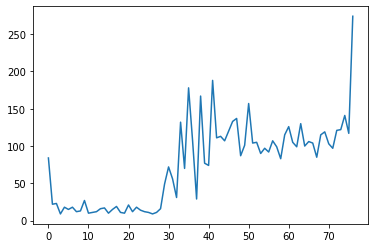

In [7]:
plt.plot(donescores)

145.0


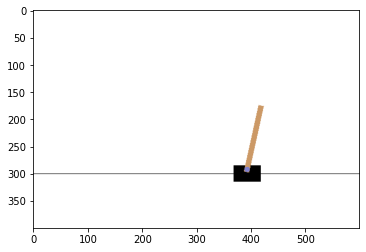

In [12]:
env = gym.make("CartPole-v1")

observation = env.reset()
observation= np.reshape(observation, (1, NS))
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

reward_sum = 0
for i in range(3000):
  action = choose_action(observation)
  observation, reward, done, info = env.step(action)
  reward_sum += reward
  observation= np.reshape(observation, (1, NS))
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()
print(reward_sum)